In [1]:
# Import necessary libraries
from sklearn.metrics.pairwise import haversine_distances
from shapely.geometry import Point, Polygon, box
from sklearn import preprocessing
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage import color
import geopandas as gpd
from PIL import Image
import pandas as pd
import numpy as np
import cv2 as cv
import scipy.io
import requests
import shapely
import pickle
import glob
import time
import math
import sys
import os

def progressbar(it, prefix="", size=60, out=sys.stdout): # Python3.3+
    count = len(it)
    def show(j):
        x = int(size*j/count)
        print("{}[{}{}] {}/{}".format(prefix, "#"*x, "."*(size-x), j, count), 
                end='\r', file=out, flush=True)
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    print("\n", flush=True, file=out)

pd.options.mode.chained_assignment = None

In [2]:
db = pd.read_csv('dict/overall.csv')

In [26]:
# Load Spain polygon
espPoly = pickle.load(open("espPoly.pkl",'rb'))

# Get next point from a lat,lng given the distance and angle (bearing)
def getNextPoint(lat1, lon1, d, brng):
    R = 6371
    lat1 = math.radians(lat1) #Current lat point converted to radians
    lon1 = math.radians(lon1) #Current long point converted to radians
    lat2 = math.asin( math.sin(lat1)*math.cos(d/R) +
        math.cos(lat1)*math.sin(d/R)*math.cos(brng))
    lon2 = lon1 + math.atan2(math.sin(brng)*math.sin(d/R)*math.cos(lat1),
                math.cos(d/R)-math.sin(lat1)*math.sin(lat2))
    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)
    return (lat2,lon2)

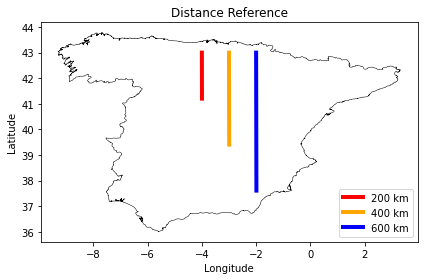

In [28]:
# Distance reference graph
x,y = espPoly.exterior.xy
plt.plot(x,y,color='black',linewidth=0.5)
nextPt = getNextPoint(43,-4,200,1.57*2)
plt.plot([-4,nextPt[1]],[43,nextPt[0]],'red',lw=4,label="200 km")
nextPt = getNextPoint(43,-3,400,1.57*2)
plt.plot([-3,nextPt[1]],[43,nextPt[0]],'orange',lw=4,label="400 km")
nextPt = getNextPoint(43,-2,600,1.57*2)
plt.plot([-2,nextPt[1]],[43,nextPt[0]],'blue',lw=4,label="600 km")
plt.legend(loc='lower right')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distance Reference')
plt.tight_layout()
plt.savefig("distanceRef.png",dpi=300)

In [5]:
# Tiny Images (16x16)
for i in progressbar(db.index,"Computing: ",20):
    fileName = db.file[i]
    img = np.array(Image.open("data/raw/{}".format(fileName)))
    res = cv.resize(img, dsize=(16,16))
    np.save("data/tinyImages/{}".format(fileName[:-4]),res)

Computing: [####################] 13099/13099



In [151]:
# Color (CIELAB) Histograms
for i in progressbar(db.index,"Computing: ",20):
    fileName = db.file[i]
    lab = color.rgb2lab(Image.open("data/raw/{}".format(fileName)))
    chans = cv.split(lab)
    
    d = np.transpose(np.array((chans[0].flatten(),chans[1].flatten(),chans[2].flatten())))
    h, edges = np.histogramdd(d,bins=(range(0,101,25),range(-100,101,14),range(-100,101,14)))

    np.save("data/cielabHistograms/{}".format(fileName[:-4]),h)

Computing: [####################] 13099/13099



In [133]:
# Line Features
for i in progressbar(db.index,"Computing: ",20):
    fileName = db.file[i]
    mat = scipy.io.loadmat("data/lineFeatures/{}.mat".format(fileName[:-4]))
    np.save("data/lineFeatures/{}".format(fileName[:-4]),mat['data'])

Computing: [####################] 13099/13099



In [17]:
# Texton Histograms
for i in progressbar(db.index,"Computing: ",20):
    fileName = db.file[i]
    mat = scipy.io.loadmat("data/textonHistograms/{}.mat".format(fileName[:-4]))
    np.save("data/textonHistograms/{}".format(fileName[:-4]),mat['hst'])

Computing: [####################] 13099/13099



In [72]:
# Tiny CIELAB Images (5x5)
for i in progressbar(db.index,"Computing: ",20):
    fileName = db.file[i]
    img = Image.open("data/raw/{}".format(fileName))
    labImg = color.rgb2lab(img)
    res = cv.resize(labImg, dsize=(5,5))
    np.save("data/tinyLabImages/{}".format(fileName[:-4]),res)

Computing: [####################] 13099/13099



In [7]:
# Gist Descriptor
for i in progressbar(db.index,"Computing: ",20):
    fileName = db.file[i]
    mat = scipy.io.loadmat("data/gistDescriptors/{}.mat".format(fileName))
    np.save("data/gistDescriptors/{}".format(fileName[:-4]),mat['data'])

Computing: [####################] 13099/13099



# Feature Analysis

In [12]:
cielabHistograms = []
gistDescriptors = []
lineAngles = []
lineLengths = []
textonHistograms = []
tinyImages = []
tinyLabImages = []

for i in progressbar(db.index,"Computing: ",20):
    fileName = db.file[i][:-4]
    cielabHistograms.append(np.load("data/cielabHistograms/{}.npy".format(fileName)))
    gistDescriptors.append(np.load("data/gistDescriptors/{}.npy".format(fileName)))

    lineFeatures = np.load("data/lineFeatures/{}.npy".format(fileName))
    lineAngles.append(lineFeatures[0])
    lineLengths.append(lineFeatures[1])

    textonHistograms.append(np.load("data/textonHistograms/{}.npy".format(fileName)))
    tinyImages.append(np.load("data/tinyImages/{}.npy".format(fileName)))
    tinyLabImages.append(np.load("data/tinyLabImages/{}.npy".format(fileName)))

np.save('features/cielabHistograms.npy', cielabHistograms, allow_pickle=True)
np.save('features/gistDescriptors.npy', gistDescriptors, allow_pickle=True)
np.save('features/lineAngles.npy', lineAngles, allow_pickle=True)
np.save('features/lineLengths.npy', lineLengths, allow_pickle=True)
np.save('features/textonHistograms.npy', textonHistograms, allow_pickle=True)
np.save('features/tinyImages.npy', tinyImages, allow_pickle=True)
np.save('features/tinyLabImages.npy', tinyLabImages, allow_pickle=True)

Computing: [####################] 13099/13099



In [3]:
cielabHistograms = np.load('features/cielabHistograms.npy', allow_pickle=True)
gistDescriptors = np.load('features/gistDescriptors.npy', allow_pickle=True)
lineAngles = np.load('features/lineAngles.npy', allow_pickle=True)
lineLengths = np.load('features/lineLengths.npy', allow_pickle=True)
textonHistograms = np.load('features/textonHistograms.npy', allow_pickle=True)
tinyImages = np.load('features/tinyImages.npy', allow_pickle=True)
tinyLabImages = np.load('features/tinyLabImages.npy', allow_pickle=True)

In [4]:
trainIdx = list(db.sample(frac=0.8, random_state=42).index.sort_values())
testIdx = list(db[~db.index.isin(trainIdx)].index.sort_values())
#db['group'] = np.where(db.index.isin(trainIdx),"train","test")
#db.to_csv("dict/overall.csv",index=False,encoding="utf-8")

In [20]:
officialDb = db[db.official == 1].reset_index(drop=True)
trainDb = db[db.group.isin(["train","validation"])].reset_index(drop=True)

In [21]:
cielabHistogramsTrain = [cielabHistograms[i] for i in trainIdx]
gistDescriptorsTrain = [gistDescriptors[i] for i in trainIdx]
lineAnglesTrain = [lineAngles[i] for i in trainIdx]
lineLengthsTrain = [lineLengths[i] for i in trainIdx]
textonHistogramsTrain = [textonHistograms[i] for i in trainIdx]
tinyImagesTrain = [tinyImages[i] for i in trainIdx]
tinyLabImagesTrain = [tinyLabImages[i] for i in trainIdx]

cielabHistogramsTest = [cielabHistograms[i] for i in testIdx]
gistDescriptorsTest = [gistDescriptors[i] for i in testIdx]
lineAnglesTest = [lineAngles[i] for i in testIdx]
lineLengthsTest = [lineLengths[i] for i in testIdx]
textonHistogramsTest = [textonHistograms[i] for i in testIdx]
tinyImagesTest = [tinyImages[i] for i in testIdx]
tinyLabImagesTest = [tinyLabImages[i] for i in testIdx]

In [22]:
# Distance formulas
def euclideanDistance(a,b):
    return np.linalg.norm(a-b)
def manhattanDistance(a,b):
    return sum(abs(int(x)-int(y)) for x,y in zip(a,b))
def chiSquaredDistance(a,b,eps=1e-10):
    a,b = np.array(a),np.array(b)
    return 0.5 * np.sum((a-b)**2 / (a+b+eps))

In [23]:
### 1-NN MODEL ###

savedDifferences = []

results = []
for i in progressbar(range(len(testIdx)),"Computing: ",20):
    # Get feature values for each iteration
    cH = cielabHistogramsTest[i]
    gD = gistDescriptorsTest[i]
    lA = lineAnglesTest[i]
    lL = lineLengthsTest[i]
    tH = textonHistogramsTest[i]
    tI = tinyImagesTest[i]
    tLI = tinyLabImagesTest[i]

    # Compute distances
    cHDiff,gDDiff,gD2Diff,lADiff,lLDiff,tHDiff,tIDiff,tLIDiff = [],[],[],[],[],[],[],[]
    for k in range(len(trainIdx)):
        cHDiff.append(chiSquaredDistance(cH,cielabHistogramsTrain[k]))
        gDDiff.append(euclideanDistance(gD,gistDescriptorsTrain[k]))
        lADiff.append(manhattanDistance(lA,lineAnglesTrain[k]))
        lLDiff.append(manhattanDistance(lL,lineLengthsTrain[k]))
        tHDiff.append(chiSquaredDistance(tH,textonHistogramsTrain[k]))
        tIDiff.append(euclideanDistance(tI,tinyImagesTrain[k]))
        tLIDiff.append(euclideanDistance(tLI,tinyLabImagesTrain[k]))

    # Standardize mean of 0, standard deviation of 1
    cHDiff = preprocessing.scale(cHDiff)
    gDDiff = preprocessing.scale(gDDiff)
    lADiff = preprocessing.scale(lADiff)
    lLDiff = preprocessing.scale(lLDiff)
    tHDiff = preprocessing.scale(tHDiff)
    tIDiff = preprocessing.scale(tIDiff)
    tLIDiff = preprocessing.scale(tLIDiff)

    # Save difference values
    savedDifferences.append(np.array((cHDiff,gDDiff,lADiff,lLDiff,tHDiff,tIDiff,tLIDiff)))

    # Calculate average of feature distances and assign to DataFrame
    finalMetric = [np.mean(np.array((a,b,c,d,e,f,g))) for a,b,c,d,e,f,g in zip(cHDiff,gDDiff,lADiff,lLDiff,tHDiff,tIDiff,tLIDiff)]
    
    # Get idx of minimum value
    closestMatch = np.argmin(finalMetric)

    # Get the point of interest & the predicted point (KNN=1)
    point = [math.radians(x) for x in (db.lat[testIdx[i]],db.lng[testIdx[i]])]
    pred = [math.radians(x) for x in (trainDb.lat[closestMatch],trainDb.lng[closestMatch])]

    # Calculate error and save
    results.append({"idx":testIdx[i],
                    "error":np.max(haversine_distances([point,pred])*6378),
                    "predLat":pred[0],
                    "predLng":pred[1]})

result_df = pd.DataFrame(results)
result_df = pd.merge(result_df,db[['lat','lng','file']].reset_index(),left_on='idx',right_on='index')
result_df = result_df[['idx','file','lat','lng','predLat','predLng','error']]

KeyboardInterrupt: 